In [1]:
import os, math, subprocess
import pandas as pd
import numpy as np

get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt

import seaborn as sns

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)
file_data = 'data.csv'

from scipy import stats

In [2]:
df = pd.read_csv(file_data)
df.columns = ['Year', 'GDP', 'UPR']


df = df.apply(pd.to_numeric, errors='coerce')
df.head(20)

,Year,GDP,UPR
0,1980,27.847,NaN
1,1981,13.875,NaN
2,1982,18.405,NaN
3,1983,27.726,NaN
4,1984,48.177,NaN
5,1985,14.999,NaN
6,1986,33.873,NaN
7,1987,42.045,NaN
8,1988,23.234,NaN
9,1989,6.293,NaN


In [3]:
# In[6]:


df.info()


# In[7]:


df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
Year    39 non-null int64
GDP     39 non-null float64
UPR     29 non-null float64
dtypes: float64(2), int64(1)
memory usage: 1016.0 bytes


,Year,GDP,UPR
count,39.0000,39.0000,29.0000
mean,1999.0000,67.7161,5.7034
std,11.4018,68.1957,2.8550
min,1980.0000,6.2930,2.1000
25%,1989.5000,22.0160,4.3000
50%,1999.0000,33.8730,5.6000
75%,2008.5000,99.9515,6.4000
max,2018.0000,241.2720,12.3000


<h1>1. Data Imputation:</h1>

Data missing có thể được thay thế bằng các giá trị sau:
    - Giá trị 0.
    - Mean.

In [4]:
df_replace= df.copy()
df_replace["UPR_replace_by_0"] =df_replace["UPR"].fillna(0)

In [5]:
df_replace[5:15]

,Year,GDP,UPR,UPR_replace_by_0
5,1985,14.999,NaN,0.0
6,1986,33.873,NaN,0.0
7,1987,42.045,NaN,0.0
8,1988,23.234,NaN,0.0
9,1989,6.293,NaN,0.0
10,1990,6.472,12.3,12.3
11,1991,7.642,10.4,10.4
12,1992,9.867,11.0,11.0
13,1993,13.181,10.6,10.6
14,1994,16.312,10.3,10.3


In [6]:
df_replace["UPR_replace_by_mean"] = df_replace["UPR"].fillna(df_replace["UPR"].mean())

In [7]:
df_replace[5:15]

,Year,GDP,UPR,UPR_replace_by_0,UPR_replace_by_mean
5,1985,14.999,NaN,0.0,5.7034
6,1986,33.873,NaN,0.0,5.7034
7,1987,42.045,NaN,0.0,5.7034
8,1988,23.234,NaN,0.0,5.7034
9,1989,6.293,NaN,0.0,5.7034
10,1990,6.472,12.3,12.3,12.3000
11,1991,7.642,10.4,10.4,10.4000
12,1992,9.867,11.0,11.0,11.0000
13,1993,13.181,10.6,10.6,10.6000
14,1994,16.312,10.3,10.3,10.3000


Bài này còn sử dụng Okun's law để suy luận tỷ lệ thất nghiệp thông qua tỷ lệ tăng trưởng GDP. Để có thể suy ra tỷ lệ thất nghiệp ta cần thực hiện các bước sau:
- Có tham số k, c (sẽ mô tả cách tính trong Data exploding).
- Tính GDP_diff.
- Tính UPR_diff.
- Tính GDP_annual_diff_rate = delta GDP / GDP cũ.
- Tính GDP_period_diff_rate

Ý nghĩa các giá trị:
- df["GDP_diff"] : Sự thay đổi GDP của năm đang xét so với năm ngay trước đó
- df["UPR_diff"] : Sự thay đổi UPR của năm đang xét so với năm ngay trước đó
- df["GDP_diff_percent"] : % thay đổi GDP của năm đang xét so với năm ngay trước đó
- df["UPR_diff_percent"] : % thay đổi UPR của năm đang xét so với năm ngay trước đó

In [8]:
(k, c) = (0.1308116527691924, -2.865579108434284)

In [9]:
df_exploding = df.copy()

# Tính different theo từng năm
df_exploding["GDP_diff"] = df_exploding["GDP"].diff()

# Chia cho giá trị của năm trước đó để tìm để tìm ra giá trị tăng trưởng thường niên
df_exploding["GDP_annual_diff_rate"] = df_exploding["GDP_diff"] / df_exploding["GDP"].shift(1)
df_exploding[:5]

,Year,GDP,UPR,GDP_diff,GDP_annual_diff_rate
0,1980,27.847,NaN,NaN,NaN
1,1981,13.875,NaN,-13.972,-0.5017
2,1982,18.405,NaN,4.530,0.3265
3,1983,27.726,NaN,9.321,0.5064
4,1984,48.177,NaN,20.451,0.7376


In [10]:
UPR = df_exploding["UPR"].values
GDP_annual_diff_rate = df_exploding["GDP_annual_diff_rate"].values

import math
# Get missing_point
missing_point = -1
for i in range(len(UPR)):
    if math.isnan(UPR[i]):
        missing_point =  i

UPR_okun= np.zeros(shape=(len(UPR),))

# Dự đoán trên phần data đã biết
UPR_okun[len(UPR) - 1] = UPR[len(UPR) - 1] 
for i in range(len(UPR) - 2, -1, -1):
    UPR_okun[i] = UPR[i + 1] + (GDP_annual_diff_rate[i + 1] - k) / c
    
# Dự đoán trên phần data chưa biết
for i in range(missing_point, -1, -1):
    UPR_okun[i] = UPR_okun[i + 1] + (GDP_annual_diff_rate[i + 1] - k) / c

In [11]:
df_replace["UPR_replace_by_Okun"] = UPR_okun

In [12]:
df_replace[0:15]

,Year,GDP,UPR,UPR_replace_by_0,UPR_replace_by_mean,UPR_replace_by_Okun
0,1980,27.847,NaN,0.0,5.7034,10.5837
1,1981,13.875,NaN,0.0,5.7034,10.3630
2,1982,18.405,NaN,0.0,5.7034,10.4313
3,1983,27.726,NaN,0.0,5.7034,10.5624
4,1984,48.177,NaN,0.0,5.7034,10.7741
5,1985,14.999,NaN,0.0,5.7034,10.4881
6,1986,33.873,NaN,0.0,5.7034,10.8816
7,1987,42.045,NaN,0.0,5.7034,10.9202
8,1988,23.234,NaN,0.0,5.7034,10.7184
9,1989,6.293,NaN,0.0,5.7034,10.4183


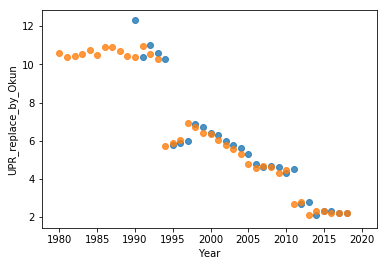

In [13]:
# Data sau khi được filling 

sns.regplot(x="Year", y="UPR", data=df_replace, fit_reg=False)
sns.regplot(x="Year", y="UPR_replace_by_Okun", data=df_replace, fit_reg=False)
# sns.regplot(x="Year", y="GDP_annual_diff_rate", data=df_exploding, fit_reg=False)

In [14]:
df_replace

,Year,GDP,UPR,UPR_replace_by_0,UPR_replace_by_mean,UPR_replace_by_Okun
0,1980,27.847,NaN,0.0,5.7034,10.5837
1,1981,13.875,NaN,0.0,5.7034,10.3630
2,1982,18.405,NaN,0.0,5.7034,10.4313
3,1983,27.726,NaN,0.0,5.7034,10.5624
4,1984,48.177,NaN,0.0,5.7034,10.7741
5,1985,14.999,NaN,0.0,5.7034,10.4881
6,1986,33.873,NaN,0.0,5.7034,10.8816
7,1987,42.045,NaN,0.0,5.7034,10.9202
8,1988,23.234,NaN,0.0,5.7034,10.7184
9,1989,6.293,NaN,0.0,5.7034,10.4183


<h1>2. Data Exploding: </h1>
Trong phần này sẽ tiến hành phân tích từng biến và phân tích nhiều biến (theo chiều thời gian).

Some statistical information of given dataset:
- GDP: 
    + Full value from 1980 to 2018 (39 values)
    + Mean of the GDP values: 67.7161 (Billions of U.S. dollars)
    + Standard deviation of the GDP values: 68.1957 (Billions of U.S. dollars)
    + Minimum of the GDP values: 6.293 (Billions of U.S. dollars)
    + Maximum of the GDP values: 241.272 (Billions of U.S. dollars)
    + Median of GDP values: 33.873 (Billions of U.S. dollars)
- Unemployment rate (UPR): 
    + 10 missing values from 1980 to 1989
    + Have 29 values from 1990 to 2018
    + Mean of the UPR values: 5.7034 (%)
    + Standard deviation of the UPR values: 2.8550 (%)
    + Minimum of the UPR values: 2.1 (%)
    + Maximum of the UPR values: 12.3 (%)
    + Median of UPR values: 5.6 (%) in 2004
- Correlation of GDP and UPR: -0.8315774406
- Distribution of GDP: see Figure.
- Distribution of UPR: see Figure.

Some analysis information of given dataset:
- GDP: Ranges from 6.293 (1989) to 241.272 (2018), with most values at the low end. The median is 33.8730.
- UPR: Ranges from 2.1 (2014) to 12.3 (1990).
- For every year, GDP decreases by about 5.6164 (Billions of U.S. dollars).
- For every year, Unemployment rate (UPR) decreases by about 0.3607.

- Từ năm 1980 đến năm 1989, GDP biến động thất thường, không ổn định, tăng/giảm đột ngột.
- Từ năm 1990 đến năm 2018, GDP tăng khá ổn định, có xu hướng tăng theo hàm tăng trưởng.
- Từ năm 1990 đến năm 2018, nhìn chung, UPR có xu hướng giảm theo hàm tuyến tính (chỉ tăng lên đột ngột vào các năm 1992, 1998 rồi lại giảm).
- GDP tăng, UPR giảm cho thấy nền kinh tế Việt Nam đang trên đà phát triển.

- There any relationship between GDP and unemployment rate:
    + For every increase of 100 in GDP, UPR decreases by about 3.23.

<h3> a. Mô hình hóa GDP: </h3>
GDP thường được mô hình hóa dựa trên 1 số mô hình sau:
- Mô hình tăng trưởng GDP thường niên.
- Mô hình tăng trưởng GDP theo chu kỳ.

Mô hình tăng trưởng GDP thường niên đã được tính trong phần trước đề làm feature cho mô hình Okun's law.

/home/system-gru/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


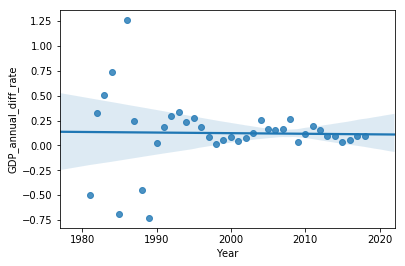

In [15]:
sns.regplot(x="Year", y="GDP_annual_diff_rate", data=df_exploding)

Mô hình GDP tăng trưởng theo chu kỳ mô tả rằng tốc độ tăng trưởng GDP thường niên sẽ giảm dần theo thời gian.

In [16]:
gdp0 = df_exploding.at[0,'GDP']
df_exploding["GDP_period_diff_rate"] = (df_exploding["GDP"] / gdp0) ** (1 / df.index) -1 

/home/system-gru/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


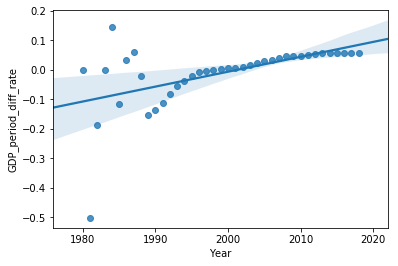

In [17]:
sns.regplot(x="Year", y="GDP_period_diff_rate", data=df_exploding)

Với mô hình tăng trưởng theo chu kỳ, ta thấy có thể dự báo rằng nền kinh tế đang tăng trưởng với tỷ lệ 0.0585 (tầm 5.85%)

In [18]:
df_exploding[35:]

,Year,GDP,UPR,GDP_diff,GDP_annual_diff_rate,GDP_period_diff_rate
35,2015,191.288,2.3,5.529,0.0298,0.0566
36,2016,201.326,2.3,10.038,0.0525,0.0565
37,2017,220.376,2.2,19.050,0.0946,0.0575
38,2018,241.272,2.2,20.896,0.0948,0.0585


<h3>b. Mô hình hóa tỷ lệ thất nghiệp:</h3> 

Tỷ lệ thất nghiệp sẽ được mô tả dựa trên mô hình linear regression theo thời gian:

/home/system-gru/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


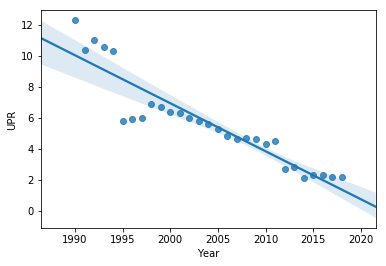

In [19]:
sns.regplot(x="Year", y="UPR", data=df_exploding)

In [20]:
# Lấy phần data có thể quan sát được
x = df_exploding["Year"][10:]
y = df_exploding["UPR"][10:]
slope, intercept, _, _, std_err = stats.linregress(x,y)

In [21]:
slope, intercept,std_err

(-0.31019704433497536, 627.3383251231527, 0.024499580683192322)

Như vậy mỗi năm tỷ lệ thất nghiệp giảm 0.31 lần với sai số khá thấp.

<h3>c. Mô hình hóa tương quan giữa UPR và GDP: </h3>

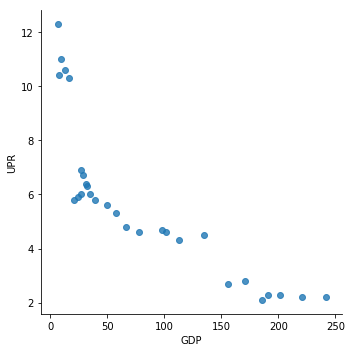

In [22]:
sns.lmplot(x="GDP", y="UPR", data=df, fit_reg=False)

Ta thấy rõ ràng GDP và UPR có tương quan. GDP tăng thì UPR giảm. Ta sẽ mô hình hóa với mô hình Okun's law.

In [23]:
# Ta tính thêm tham số UPR_diff
df_exploding["UPR_diff"] = df_exploding["UPR"].diff()
# UPR diff được normal theo rate để có thể quan sát chung với GDP_annual_diff_rate
df_exploding["UPR_diff"] /= 100

In [24]:
df_exploding

,Year,GDP,UPR,GDP_diff,GDP_annual_diff_rate,GDP_period_diff_rate,UPR_diff
0,1980,27.847,NaN,NaN,NaN,0.0000,NaN
1,1981,13.875,NaN,-13.972,-0.5017,-0.5017,NaN
2,1982,18.405,NaN,4.530,0.3265,-0.1870,NaN
3,1983,27.726,NaN,9.321,0.5064,-0.0015,NaN
4,1984,48.177,NaN,20.451,0.7376,0.1469,NaN
5,1985,14.999,NaN,-33.178,-0.6887,-0.1164,NaN
6,1986,33.873,NaN,18.874,1.2584,0.0332,NaN
7,1987,42.045,NaN,8.172,0.2413,0.0606,NaN
8,1988,23.234,NaN,-18.811,-0.4474,-0.0224,NaN
9,1989,6.293,NaN,-16.941,-0.7291,-0.1523,NaN


/home/system-gru/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


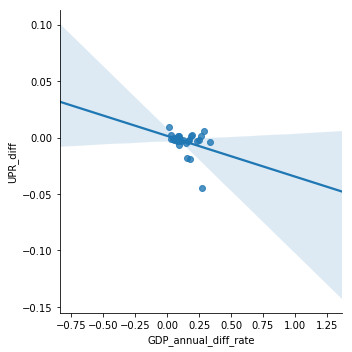

In [25]:
sns.lmplot(x="GDP_annual_diff_rate", y="UPR_diff", data=df_exploding)

In [26]:
slope, intercept, _, _, std_err = stats.linregress(
    df_exploding["UPR_diff"][11:], df_exploding["GDP_annual_diff_rate"][11:]
)

In [27]:
k = intercept
c = slope

(k, c, std_err)

(0.1308116527691924, -2.865579108434284, 1.655694837516535)

Như vậy cứ mỗi % tăng trưởng GDP thì tỷ lệ thất nghiệp giảm 2.86%. 

<h1>3. Feature Extraction: </h1>

 

In [28]:
df_exploding.columns

Index(['Year', 'GDP', 'UPR', 'GDP_diff', 'GDP_annual_diff_rate', 'GDP_period_diff_rate', 'UPR_diff'], dtype='object')

<h3>a) GDP: </h3>
GDP là giá trị thị trường của tất cả hàng hóa và dịch vụ cuối cùng được sản xuất ra trong phạm vi một lãnh thổ nhất định (thường là quốc gia) trong một thời kỳ nhất định (thường là một năm), là dấu hiệu để nhận biết sức khỏe nền kinh tế.

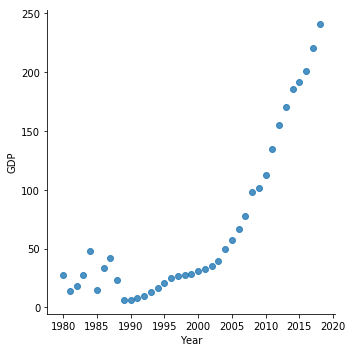

In [29]:
sns.lmplot(x="Year", y="GDP", data=df, fit_reg=False)

Dựa vào biểu đồ, ta thấy nền kinh tế có sự bất ổn và giảm tăng trưởng trong giai đoạn 1980-1990 nhưng khởi sắc và tăng trưởng ổn định trong các năm gần đây và dự báo tiếp tục tăng trưởng

<h3>b) GDP_annual_diff_rate và GDP_period_diff_rate:</h3>

Mức GDP tăng trưởng hằng năm và Mức GDP tăng trưởng theo chu kỳ.

/home/system-gru/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


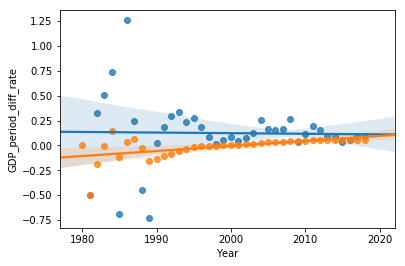

In [30]:
# fig, ax = plt.subplots(1, 2)
sns.regplot(x="Year", y="GDP_annual_diff_rate", data=df_exploding)
sns.regplot(x="Year", y="GDP_period_diff_rate", data=df_exploding)

In [31]:
x = df_exploding["Year"][1:]
y = df_exploding["GDP_annual_diff_rate"][1:]
slope_anual, intercept_anual, _, _, std_err_anual = stats.linregress(x,y)

In [32]:
x = df_exploding["Year"]
y = df_exploding["GDP_period_diff_rate"]
slope_period, intercept_period, _, _, std_err_period = stats.linregress(x,y)

In [33]:
print("Annual: ", slope_anual, intercept_anual, std_err_anual)
print("Period: ", slope_period, intercept_period, std_err_period)

Annual:  -0.0006114143361329195 1.3457802157441763 0.005049992257675005
Period:  0.005050517589156203 -10.107185003568674 0.001277678906920788


Ta thấy với feature "GDP_annual_diff_rate" dẫn tới dự báo nền kinh tế đang giảm tăng trưởng trong khi có vẻ nền kinh tế đang tăng trường. 
Feature "GDP_period_diff_rate" dẫn tới dự báo rằng nền kinh tế đang tăng trưởng.

<h3>c) UPR:</h3>
Thất nghiệp, trong kinh tế học, là tình trạng người lao động muốn có việc làm mà không tìm được việc làm (từ Hán-Việt: thất - rỗng, hết; nghiệp - công việc). Tỷ lệ thất nghiệp là phần trăm số người lao động không có việc làm trên tổng số lực lượng lao động xã hội.

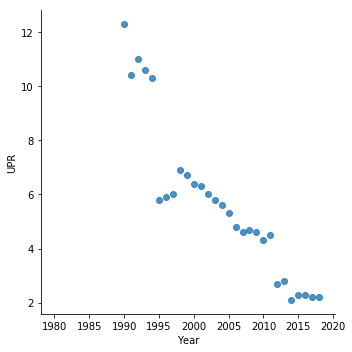

In [34]:
sns.lmplot(x="Year", y="UPR", data=df_exploding, fit_reg=False)

Theo thời gian thì tỷ lệ thất nghiệp đang giảm.

<h3>d) UPR_diff:</h3>
UPR_diff là features để estimate parameter của mô hình Okun's law.

/home/system-gru/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


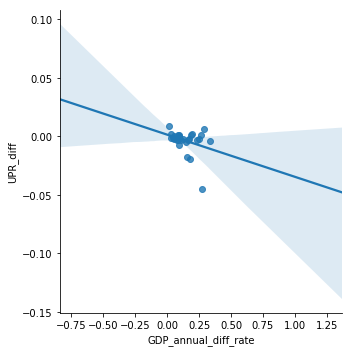

In [35]:
sns.lmplot(x="GDP_annual_diff_rate", y="UPR_diff", data=df_exploding)

<h1>4. Discussion: </h1>

 

Dựa vào bộ dữ liệu này, bằng thống kê và phân tích, ta nhận thấy rằng nền kinh tế Việt Nam đang trên đà phát triển.
Tuy nhiên với chỉ 2 dữ liệu về GDP, và UPR là chưa đủ để phân tích, đánh giá một cách chính xác tình hình kinh tế Việt Nam trong giai đoạn từ năm 1980 đến 2018. Nếu có thêm dữ liệu về lạm phát, nợ công, xuất nhập khẩu, tăng trưởng tín dụng,... ta sẽ đánh giá chính xác, chi tiết hơn về tình hình kinh tế Việt Nam. Hơn nữa, ta sẽ có nhiều cơ sở để dự đoán tình hình kinh tế Việt Nam từ sau năm 2018.